# Import Dependencies

In [1]:
!pip install torchsummary
import os
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.garenanow.com


In [2]:
%cd project
!pwd
import utils

/home/wenhao.lau/project
/home/wenhao.lau/project


# Preparing the Data

In [3]:
# Looking into the directory
data_dir = './CK+48'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['train', 'validation']
Train Classes - ['fear', 'surprise', 'happy', 'sadness', 'contempt', 'disgust', 'anger']
Validation Classes - ['fear', 'surprise', 'happy', 'sadness', 'contempt', 'disgust', 'anger']


In [4]:
# Data transforms (Gray Scaling & data augmentation)
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.Resize((48,48)),
                         tt.ToTensor()])

valid_tfms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.ToTensor()])

In [5]:
# Emotion Detection datasets
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/validation', train_tfms)

In [6]:
batch_size = 100

In [7]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

Feature batch shape: torch.Size([100, 1, 48, 48])
Labels batch shape: torch.Size([100])


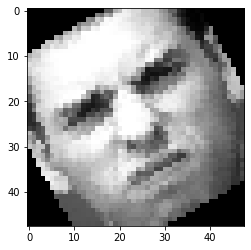

Label: 2


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([1, 48, 48])


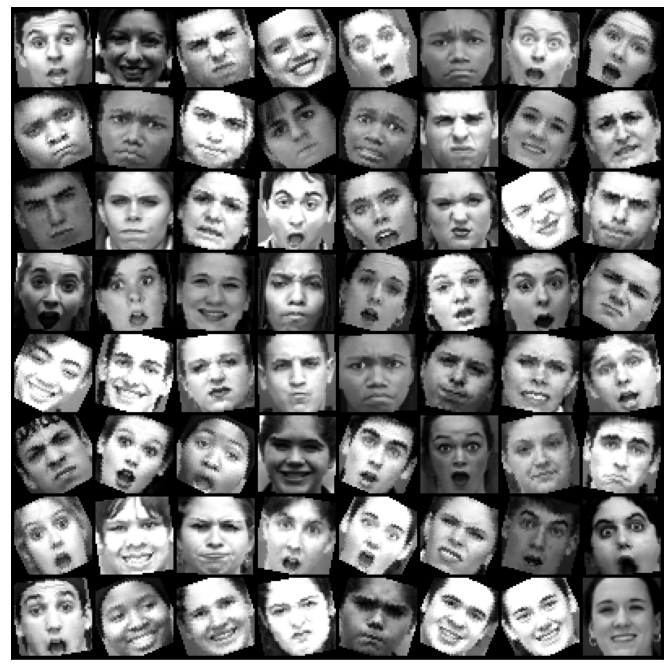

In [10]:
show_batch(train_dl)

# Compute average pixel intensity over all training set and all channels

In [11]:
mean = 0.0
meansq = 0.0
count = 0

for index, (data, _) in enumerate(train_dl):
    mean = data.sum()
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)
print("mean: " + str(total_mean))
print("std: " + str(total_std))

mean: tensor(0.0483)
std: tensor(0.5824)


In [12]:
device= torch.device("cuda")
print(device)

cuda


# Define EmotionNetNano class

In [13]:
class EmotionNetNano(nn.Module):
    
    def __init__(self, filters):
        super(EmotionNetNano, self).__init__()

        # Fundamental Block 
        self.layer1 = nn.Conv2d(1, filters[0], kernel_size=3, padding=1)
        self.layer2 = nn.Conv2d(filters[0], filters[1], kernel_size=3, padding=1)
        self.layer3 = nn.Conv2d(filters[1], filters[2], kernel_size=3, padding=1)
        self.layer4 = nn.Conv2d(filters[2], filters[3], kernel_size=3, padding=1)
        self.layer5 = nn.Conv2d(filters[3], filters[4], kernel_size=3, padding=1)
        self.layer6 = nn.Conv2d(filters[4], filters[5], kernel_size=3, padding=1)
        self.layer7 = nn.Conv2d(filters[5], filters[6], kernel_size=3, padding=1)
        self.layer8 = nn.Conv2d(filters[6], filters[7], kernel_size=3, padding=1, stride=2)
        
        # 1x1 Conv Layer 1
        self.identity1 = nn.Conv2d(filters[0], filters[8], kernel_size=1, stride=2)

        # CNN Block 1
        self.layer9 = nn.Conv2d(filters[7], filters[8], kernel_size=3, padding=1)
        self.layer10 = nn.Conv2d(filters[8], filters[9], kernel_size=3, padding=1)
        self.layer11 = nn.Conv2d(filters[9], filters[10], kernel_size=3, padding=1)
        self.layer12 = nn.Conv2d(filters[10], filters[11], kernel_size=3, padding=1)
        self.layer13 = nn.Conv2d(filters[11], filters[12], kernel_size=3, padding=1)
        self.layer14 = nn.Conv2d(filters[12], filters[13], kernel_size=3, padding=1, stride=2)
        
        # 1x1 Conv Layer 2
        self.identity2 = nn.Conv2d(filters[7], filters[19], kernel_size=1, stride=2)

        # CNN Block 2
        self.layer15 = nn.Conv2d(filters[13], filters[14], kernel_size=3, padding=1)
        self.layer16 = nn.Conv2d(filters[14], filters[15], kernel_size=3, padding=1)
        self.layer17 = nn.Conv2d(filters[15], filters[16], kernel_size=3, padding=1)
        self.layer18 = nn.Conv2d(filters[16], filters[17], kernel_size=3, padding=1)
        self.layer19 = nn.Conv2d(filters[17], filters[18], kernel_size=3, padding=1)
        self.layer20 = nn.AvgPool2d((12,12))

        # Linear Layer
        self.linear = nn.Linear(64, 7)

    def forward(self, x):
        
        # Fundamental Block 
        layer1_out = torch.relu(self.layer1(x))
        layer2_out = torch.relu(self.layer2(layer1_out))
        layer3_out = torch.relu(self.layer3(layer2_out))
        layer4_out = torch.relu(self.layer4(layer1_out + layer3_out))
        layer5_out = torch.relu(self.layer5(layer4_out))
        layer6_out = torch.relu(self.layer6(layer1_out + layer3_out + layer5_out))
        layer7_out = torch.relu(self.layer7(layer6_out))
        layer8_out = torch.relu(self.layer8(layer1_out + layer5_out + layer7_out))
        
        # 1x1 Conv Layer 1
        identity1_out = self.identity1(layer1_out + layer3_out + layer5_out)

        # CNN Block 1
        layer9_out = torch.relu(self.layer9(layer8_out))
        layer10_out = torch.relu(self.layer10(layer9_out + identity1_out))
        layer11_out = torch.relu(self.layer11(layer10_out))
        layer12_out = torch.relu(self.layer12(layer9_out + layer11_out))
        layer13_out = torch.relu(self.layer13(layer12_out))
        layer14_out = torch.relu(self.layer14(layer9_out + layer11_out + layer13_out + identity1_out))
        
        # 1x1 Conv Layer 2
        identity2_out = self.identity2(layer8_out + layer11_out + layer13_out + identity1_out)

        # CNN Block 2
        layer15_out = torch.relu(self.layer15(layer14_out))
        layer16_out = torch.relu(self.layer16(layer15_out + identity2_out))
        layer17_out = torch.relu(self.layer17(layer16_out))
        layer18_out = torch.relu(self.layer18(layer15_out + layer17_out + identity2_out))
        layer19_out = torch.relu(self.layer19(layer18_out))
        layer20_out = self.layer20(layer15_out + layer17_out + layer19_out + identity2_out)

        # Linear Layer
        y = layer20_out.view(-1, 64)
        z = self.linear(y)
        z_hat = torch.softmax(z, dim=1)

        return z_hat

# Build the net with the following filter sizes:

In [14]:
net=EmotionNetNano([
    11,9,11,8,11,7,11,27,
    27,19,27,26,27,36,
    64,39,64,24,64,64
])

# Send the weights of the networks to the GPU

In [15]:
net = net.to(device)
summary(net, (1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 48, 48]             110
            Conv2d-2            [-1, 9, 48, 48]             900
            Conv2d-3           [-1, 11, 48, 48]             902
            Conv2d-4            [-1, 8, 48, 48]             800
            Conv2d-5           [-1, 11, 48, 48]             803
            Conv2d-6            [-1, 7, 48, 48]             700
            Conv2d-7           [-1, 11, 48, 48]             704
            Conv2d-8           [-1, 27, 24, 24]           2,700
            Conv2d-9           [-1, 27, 24, 24]             324
           Conv2d-10           [-1, 27, 24, 24]           6,588
           Conv2d-11           [-1, 19, 24, 24]           4,636
           Conv2d-12           [-1, 27, 24, 24]           4,644
           Conv2d-13           [-1, 26, 24, 24]           6,344
           Conv2d-14           [-1, 27,

# Choose the criterion

In [16]:
criterion = nn.CrossEntropyLoss()

# Function to evaluate the network on the test set

In [17]:
def eval_on_dataset_loader(model, dataset_loader):

    running_error=0
    num_batches=0

    for minibatch_data, minibatch_label in dataset_loader:
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # normalize the minibatch
        inputs = minibatch_data

        # feed it to the network
        scores=model(inputs) 

        # compute the error made on this batch
        error = utils.get_error(scores, minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print('error rate on dataset =', total_error*100 ,'percent')

# Do 200 passes through the training set

In [18]:
start=time.time()

for epoch in range(200):
    
    initial_lr = 1e-3
    if epoch < 81:
        my_lr = initial_lr
    elif epoch >= 81 and epoch < 121:
        my_lr = initial_lr * 1e-1
    elif epoch >= 121 and epoch < 161:
        my_lr = initial_lr * 1e-2
    elif epoch >= 161 and epoch < 181:
        my_lr = initial_lr * 1e-3
    elif epoch >=181:
        my_lr = initial_lr * 0.5 * 1e-3
    else:
        my_lr = initial_lr

    optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)

    running_loss=0
    running_error=0
    num_batches=0
 
    for minibatch_data, minibatch_label in train_dl:
    
        # Set the gradients to zeros
        optimizer.zero_grad()

        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # normalize the minibatch
        inputs = minibatch_data

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net(inputs) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion(scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error(scores.detach(), minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if (epoch+1)%5 == 0:
        print('epoch=',epoch+1, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        
net.eval()
with torch.no_grad():
    eval_on_dataset_loader(net, valid_dl)

epoch= 5 	 time= 0.03807400465011597 min 	 lr= 0.001 	 loss= 1.883762968911065 	 error= 74.57343604829576 percent
epoch= 10 	 time= 0.0791797121365865 min 	 lr= 0.001 	 loss= 1.8852585421668158 	 error= 74.82375568813748 percent
epoch= 15 	 time= 0.11874082485834757 min 	 lr= 0.001 	 loss= 1.877353721194797 	 error= 74.27330811818442 percent
epoch= 20 	 time= 0.15872156222661335 min 	 lr= 0.001 	 loss= 1.8734692335128784 	 error= 74.80204436514113 percent
epoch= 25 	 time= 0.19691978693008422 min 	 lr= 0.001 	 loss= 1.8607704771889582 	 error= 72.34610650274489 percent
epoch= 30 	 time= 0.23599860270818074 min 	 lr= 0.001 	 loss= 1.776472528775533 	 error= 61.10217240121629 percent
epoch= 35 	 time= 0.2749674638112386 min 	 lr= 0.001 	 loss= 1.750023815366957 	 error= 59.52490568161011 percent
epoch= 40 	 time= 0.31401504278182985 min 	 lr= 0.001 	 loss= 1.7192614873250325 	 error= 55.224776930279205 percent
epoch= 45 	 time= 0.35262630780537924 min 	 lr= 0.001 	 loss= 1.70952314800686

# Save the model

In [19]:
torch.save(net.state_dict(), 'trained_models/emotionnet_nano_with_ck+48(36%, rotation).pt')

# Load the model

In [20]:
model=EmotionNetNano([
    11,9,11,8,11,7,11,27,
    27,19,27,26,27,36,
    64,39,64,24,64,64
])
model.load_state_dict(torch.load('trained_models/emotionnet_nano_with_ck+48(36%, rotation).pt'))
model.to(device)
model.eval()

EmotionNetNano(
  (layer1): Conv2d(1, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer2): Conv2d(11, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer3): Conv2d(9, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer4): Conv2d(11, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer5): Conv2d(8, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer6): Conv2d(11, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer7): Conv2d(7, 11, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer8): Conv2d(11, 27, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (identity1): Conv2d(11, 27, kernel_size=(1, 1), stride=(2, 2))
  (layer9): Conv2d(27, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer10): Conv2d(27, 19, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer11): Conv2d(19, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer12): Conv2d(27, 26, kernel_size=(3, 3), stride=(1, 1), pad

In [21]:
eval_on_dataset_loader(net, train_dl)
eval_on_dataset_loader(net, valid_dl)

error rate on dataset = 35.992339584562515 percent
error rate on dataset = 36.17021441459656 percent
